# Task A: PneumoniaMNIST

## 1. Import library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,accuracy_score
from torch.optim import lr_scheduler
import copy


## 2. Feature engineering

In [6]:
# Get the data path
path = os.path.abspath(os.path.join('..', 'Datasets/pneumoniamnist.npz'))
print(path)

def data_process(path):
    # Get the dataset
    data = np.load(path)
    # Find the keys oof the dataset
    print(data.keys())
    # Extracting features and labels
    # Nomalization: dividing all features by 255
    train_X = data['train_images']/255.0
    train_y = data['train_labels']
    val_X = data['val_images']/255.0
    val_y = data['val_labels']
    test_X = data['test_images']/255.0
    test_y = data['test_labels']
    return train_X, train_y, val_X, val_y, test_X, test_y

# Determine whether to save the image plotted (These images are used to write report)
# It should be false when you run the program
save_image = True

# set the random seed to 42
torch.manual_seed(42)
train_X, train_y, val_X, val_y, test_X, test_y = data_process(path)


# create train_loader for training
train_tensor_X = torch.tensor(train_X, dtype=torch.float32).unsqueeze(1)

# One-hot encoder to process y (This is used for CrossEntropyLoss)
encoder = OneHotEncoder(sparse=False)

train_tensor_y = torch.tensor(encoder.fit_transform(train_y))
print(train_tensor_X.shape)
train_loader = DataLoader(TensorDataset(train_tensor_X, train_tensor_y), batch_size = 64, shuffle = True)
print(train_loader)

# create validation_loader for validation
val_tensor_X = torch.tensor(val_X, dtype=torch.float32).unsqueeze(1)
val_tensor_y = torch.tensor(encoder.fit_transform(val_y))
val_loader = DataLoader(TensorDataset(val_tensor_X, val_tensor_y), shuffle = False)

# create test_loader for testing
test_tensor_X = torch.tensor(test_X, dtype=torch.float32).unsqueeze(1)
test_tensor_y = torch.tensor(encoder.fit_transform(test_y))
test_loader = DataLoader(TensorDataset(test_tensor_X, test_tensor_y), shuffle = False)

print(train_X.shape)


c:\Users\xrw\Desktop\UCL\APPLIED MACHINE LEARNING\AMLS_assignment23_24-\Datasets\pneumoniamnist.npz
KeysView(NpzFile 'c:\\Users\\xrw\\Desktop\\UCL\\APPLIED MACHINE LEARNING\\AMLS_assignment23_24-\\Datasets\\pneumoniamnist.npz' with keys: train_images, val_images, test_images, train_labels, val_labels...)
torch.Size([4708, 1, 28, 28])
(4708, 28, 28)


d:\anaconda\envs\developing\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\anaconda\envs\developing\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\anaconda\envs\developing\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 3. Convolutional Neural Network(CNN)

Epoch: 1, train_loss: 43.700
Epoch: 1, Accuracy of the network on the train images: 74.21%
Epoch: 1, Accuracy of the network on the val images: 74.24%
Epoch: 1, Accuracy of the network on the test images: 62.50%
Epoch: 1, val_loss: 298.583
Epoch: 1, test_loss: 434.122
Epoch: 2, train_loss: 41.918
Epoch: 2, Accuracy of the network on the train images: 74.21%
Epoch: 2, Accuracy of the network on the val images: 74.24%
Epoch: 2, Accuracy of the network on the test images: 62.50%
Epoch: 2, val_loss: 295.607
Epoch: 2, test_loss: 424.437
Epoch: 3, train_loss: 41.338
Epoch: 3, Accuracy of the network on the train images: 74.21%
Epoch: 3, Accuracy of the network on the val images: 74.24%
Epoch: 3, Accuracy of the network on the test images: 62.50%
Epoch: 3, val_loss: 291.072
Epoch: 3, test_loss: 416.937
Epoch: 4, train_loss: 40.482
Epoch: 4, Accuracy of the network on the train images: 74.21%
Epoch: 4, Accuracy of the network on the val images: 74.24%
Epoch: 4, Accuracy of the network on the t

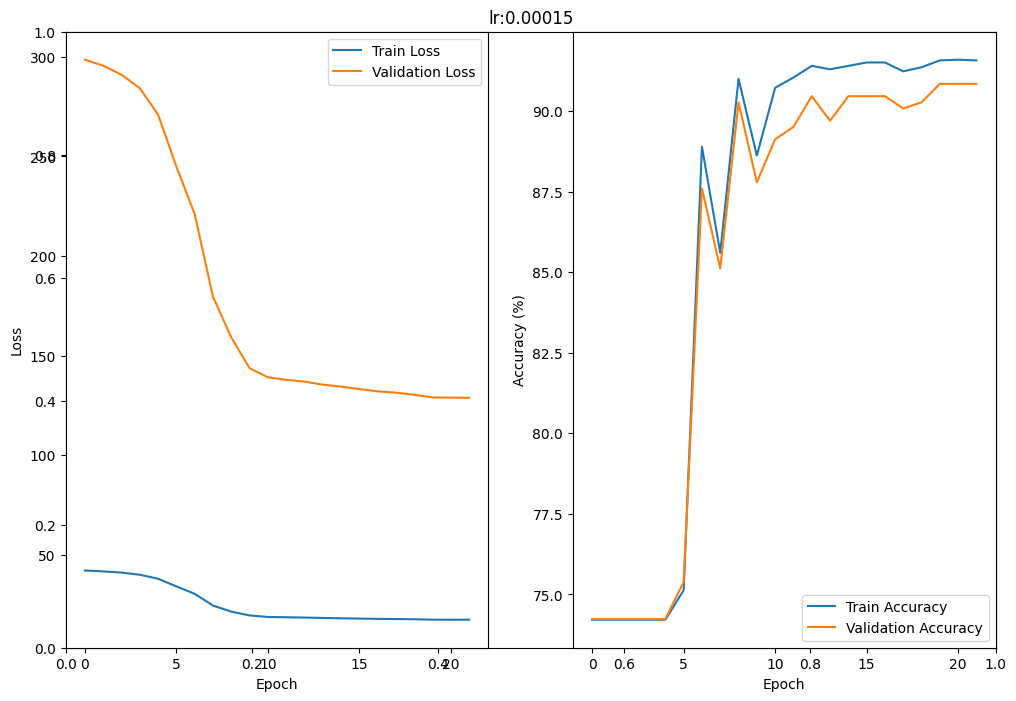

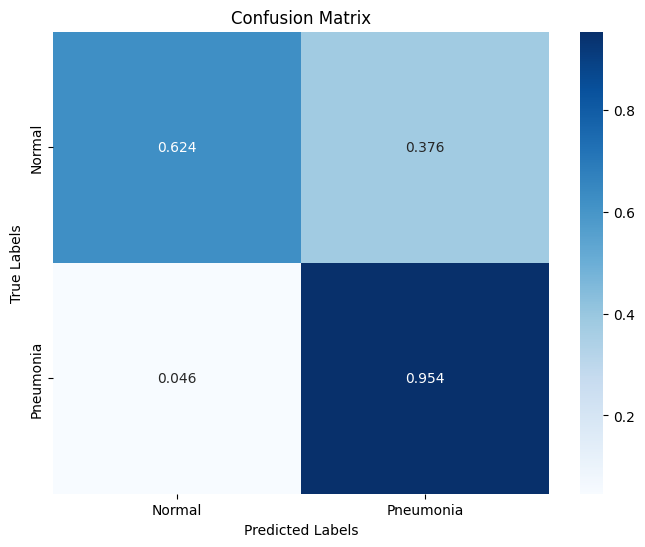

Recall:  0.9538461538461539
Precision:  0.808695652173913
F1 score:  0.8752941176470589
Epoch: 0, Accuracy of the network on the test images: 83.01%
test accuracy:  83.01282051282051
loss:  tensor(239.3427, dtype=torch.float64)
Epoch: 1, train_loss: 47.083
Epoch: 1, Accuracy of the network on the train images: 74.21%
Epoch: 1, Accuracy of the network on the val images: 74.24%
Epoch: 1, Accuracy of the network on the test images: 62.50%
Epoch: 1, val_loss: 303.268
Epoch: 1, test_loss: 420.218
Epoch: 2, train_loss: 42.293
Epoch: 2, Accuracy of the network on the train images: 74.21%
Epoch: 2, Accuracy of the network on the val images: 74.24%
Epoch: 2, Accuracy of the network on the test images: 62.50%
Epoch: 2, val_loss: 300.409
Epoch: 2, test_loss: 423.731
Epoch: 3, train_loss: 42.194
Epoch: 3, Accuracy of the network on the train images: 74.21%
Epoch: 3, Accuracy of the network on the val images: 74.24%
Epoch: 3, Accuracy of the network on the test images: 62.50%
Epoch: 3, val_loss: 29

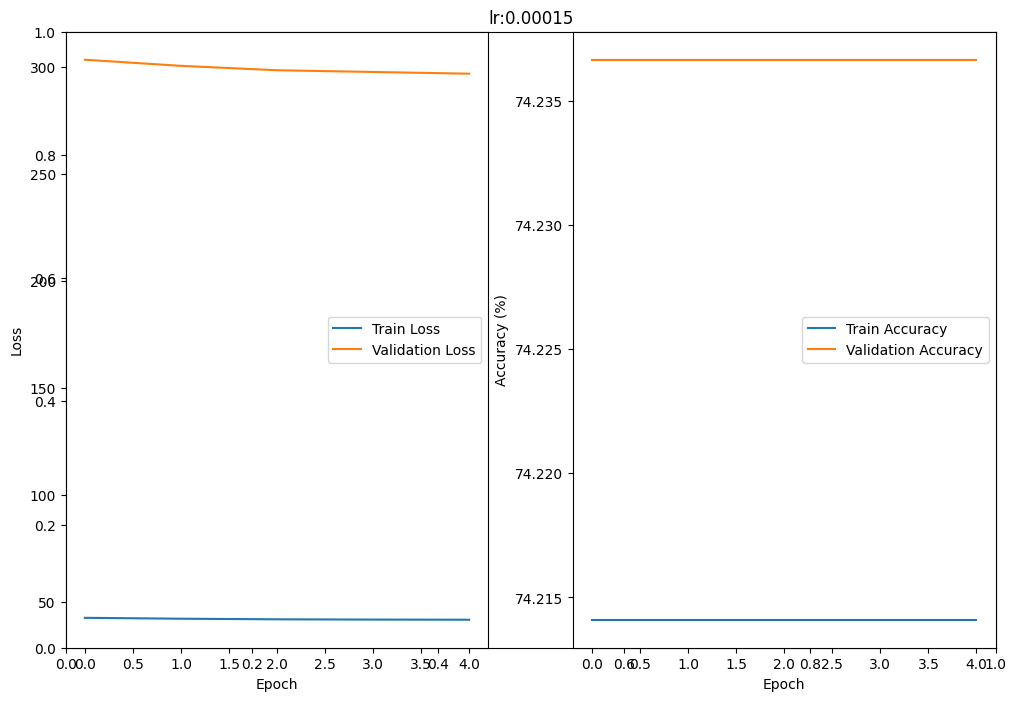

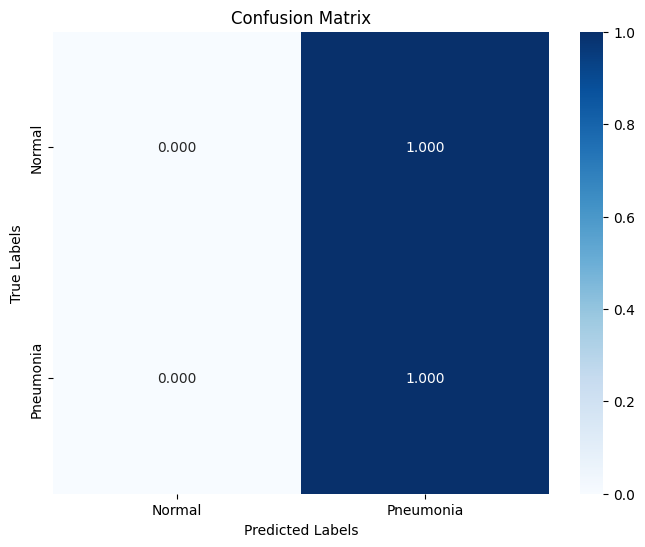

Recall:  1.0
Precision:  0.625
F1 score:  0.7692307692307693
Epoch: 0, Accuracy of the network on the test images: 62.50%
test accuracy:  62.5
loss:  tensor(434.4665, dtype=torch.float64)
Epoch: 1, train_loss: 44.917
Epoch: 1, Accuracy of the network on the train images: 74.21%
Epoch: 1, Accuracy of the network on the val images: 74.24%
Epoch: 1, Accuracy of the network on the test images: 62.50%
Epoch: 1, val_loss: 299.310
Epoch: 1, test_loss: 428.908
Epoch: 2, train_loss: 41.786
Epoch: 2, Accuracy of the network on the train images: 74.21%
Epoch: 2, Accuracy of the network on the val images: 74.24%
Epoch: 2, Accuracy of the network on the test images: 62.50%
Epoch: 2, val_loss: 293.406
Epoch: 2, test_loss: 428.705
Epoch: 3, train_loss: 40.905
Epoch: 3, Accuracy of the network on the train images: 74.21%
Epoch: 3, Accuracy of the network on the val images: 74.24%
Epoch: 3, Accuracy of the network on the test images: 62.50%
Epoch: 3, val_loss: 285.356
Epoch: 3, test_loss: 408.419
Epoch

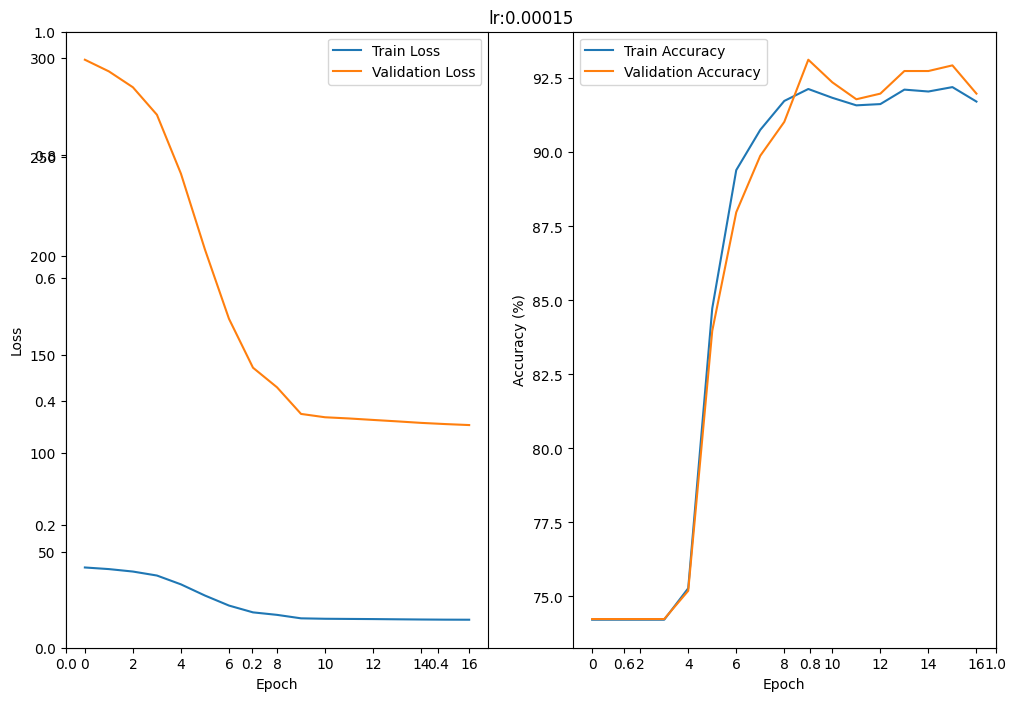

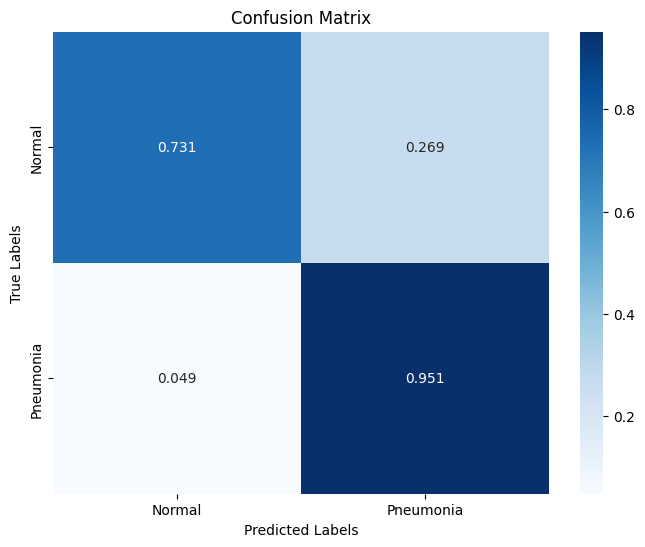

Recall:  0.9512820512820512
Precision:  0.8548387096774194
F1 score:  0.9004854368932039
Epoch: 0, Accuracy of the network on the test images: 86.86%
test accuracy:  86.85897435897436
loss:  tensor(220.0724, dtype=torch.float64)
CNN_best_accuracy:  86.85897435897436


In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.reshape(-1, 16 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.reshape(-1, 16 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 7 * 7,2)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.reshape(-1, 16 * 7 * 7)
        x = self.fc1(x)
        return x


def train_and_evaluate(model, train_loader, loss_criterion, optimizer, num_epoch, val_loader,scheduler, test_loader):
    # stop condition
    best_validation_loss = float('inf')
    # how many no_improvement the model can tolerate
    patience = 2
    
    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []
    for epoch_num in range(num_epoch):
        model.train()
        epoch_loss = 0.0
        for i, data in enumerate(train_loader):
            X, y = data
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        print(f'Epoch: {epoch_num + 1}, train_loss: {epoch_loss :.3f}')
        train_accuracy, train_loss = predict(model, train_loader, epoch_num, 'train', loss_criterion)
        val_accuracy, val_loss = predict(model, val_loader, epoch_num, 'val', loss_criterion)
        test_accuracy, test_loss = predict(model, test_loader, epoch_num, 'test', loss_criterion)
        print(f'Epoch: {epoch_num + 1}, val_loss: {val_loss :.3f}')
        print(f'Epoch: {epoch_num + 1}, test_loss: {test_loss :.3f}')
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        if  best_validation_loss - val_loss > val_loss/100:
            best_validation_loss = val_loss
            best_epoch = epoch_num
            # Count how many epochs have not improved the model since the best epoch, if it >= patience, the train process will stop early
            early_stopping_counter = 0
            # save the best model
            best_model_state_dict = copy.deepcopy(model.state_dict())
        else:
            early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f'Best epoch: {best_epoch + 1}, finish')
            break
    model.load_state_dict(best_model_state_dict)
        
    return model, train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list
    
# model : The model after training, 
# loader: The dataset need to be predicted by the model
# epoch_num: The number of the current epoch. 
# type: used to clarify which dataset is being predicted : (train, test, val)
def predict(model, loader, epoch_num, type, loss_criterion):
    model.eval()
    correct = 0
    total = 0
    epoch_loss = 0
    with torch.no_grad():
        for i, samples in enumerate(loader):
            X, y = samples
            outputs = model(X)
            loss = loss_criterion(outputs, y)
            _, predicted = torch.max(outputs.data, axis = 1)
            total += y.size(0)
            # train_loader is encoded for training, while others are not encoded. y is different in these three different datasets([1,0] in train_loader or [0] in others)
            correct += (predicted == np.argmax(y,axis = 1)).sum().item()
            epoch_loss += loss
    # print(correct)
    print(f'Epoch: {epoch_num + 1}, Accuracy of the network on the {type} images: {100 * correct / total:.2f}%')
    return 100 * correct / total, epoch_loss

def get_confusion_matrix(model, X, y, lr):
    output = model(X)
    _, predict_y = torch.max(output.data, axis = 1)
    true_y = np.argmax(y, axis = 1)
    conf_matrix = confusion_matrix(true_y , predict_y)
    # compute the number of every classes, for the normalization of confusion matrix
    class_totals = conf_matrix.sum(axis=1, keepdims=True)
    # normalize the confusion matrix
    normalized_confusion_matrix = conf_matrix / class_totals
    
    # labels
    labels = ['Normal', 'Pneumonia']

    # create images for confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.3f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    if(save_image == True):
        plt.savefig(f"C:/Users/xrw/Desktop/UCL/APPLIED MACHINE LEARNING/AMLS_I_assignment_kit/images/taska/confusion{lr}.png")
    plt.show()
    # True Positives
    TP = conf_matrix[1][1]  
    #False Positive
    FP = conf_matrix[0][1]
    # False Negatives
    FN = conf_matrix[1][0]  

    # Compute Recall
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print('Recall: ', recall)
    print('Precision: ', precision)
    print('F1 score: ', f1_score)
    
    

def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, lr, epoch_num):
    plt.figure(figsize=(12, 8))
    plt.title(f'lr:{lr}')
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    if(save_image == True):
        plt.savefig(f"C:/Users/xrw/Desktop/UCL/APPLIED MACHINE LEARNING/AMLS_I_assignment_kit/images/taska/{lr}.png")
    plt.show()
   
    
type = ['train', 'test', 'val']
# l2 regularization
def TaskA(model, lr, l2_lambda, lr_decay, lr_decay_rate, epoch_num):
    # Use CrossEntropyLoss to train the model
    loss_criterion = nn.CrossEntropyLoss()
    
    # optimizer for the CNN
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = l2_lambda)
    # learning rate decay
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=lr_decay_rate)
    
    model, train_accuracy, val_accuracy, train_loss, val_loss = train_and_evaluate(model, train_loader, loss_criterion, optimizer, epoch_num, val_loader, scheduler, test_loader)
    plot_metrics(train_loss, train_accuracy, val_loss, val_accuracy, lr, epoch_num)
    # After the model is trained, get the confusion matrix and recall
    get_confusion_matrix(model, test_tensor_X, test_tensor_y, lr)
    accuracy, test_loss = predict(model, test_loader, -1, 'test', loss_criterion)
    print('test accuracy: ', accuracy)
    print('loss: ', test_loss)
    # trained_model = train(model,train_loader, loss_criterion, optimizer, 30)
    # predict(trained_model, test_loader)
    return model, accuracy

def main_A(model_name):
    best_accuracy = 0
    for i in range(0,3):
        if(model_name == 'CNN'):
            model, accuracy = TaskA(model = CNN(), l2_lambda=0.03, lr = 0.00015, lr_decay = False, lr_decay_rate = 0.1, epoch_num = 30)
        elif(model_name == 'CNN2'):
            model, accuracy = TaskA(model = CNN2(), l2_lambda=0.03, lr = 0.0002, lr_decay = False, lr_decay_rate = 0.1, epoch_num = 30)
        elif(model_name == 'CNN3'):
            model, accuracy = TaskA(model = CNN3(), l2_lambda=0.03, lr = 0.00015, lr_decay = False, lr_decay_rate = 0.1, epoch_num = 30)
        else:
            print("False name")
        if(accuracy > best_accuracy):
            best_accuracy = accuracy
            best_model = model
    print(f'{model_name}_best_accuracy: ', best_accuracy)
    torch.save(best_model, f'{model_name}_best_model.pth')
    
main_A('CNN')




## 4. Support Vector Machine (SVM)

In [46]:
flatten_train_X = train_X.reshape(train_X.shape[0], -1)
flatten_test_X = test_X.reshape(test_X.shape[0], -1)
# create SVM model
svm_classifier = SVC(kernel='rbf', C = 2.0)
# svm_classifier = SVC(kernel='linear', C = 0.3)

# Train SVM
svm_classifier.fit(flatten_train_X, train_y)

# predict according to SVM
y_pred = svm_classifier.predict(flatten_test_X)

# Compute accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
conf_matrix = confusion_matrix(test_y, y_pred)

# True Positive
TP = conf_matrix[1][1]  
# False Positive
FP = conf_matrix[0][1]
# False Negatives
FN = conf_matrix[1][0]

# Compute Recall
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1 score: ', f1_score)

get_confusion_matrix(svm_classifier, test_tensor_X, test_tensor_y, 'SVM')
    


d:\anaconda\envs\developing\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 86.38%
Recall:  0.9948717948717949
Precision:  0.8237791932059448
F1 score:  0.9012775842044135


TypeError: 'SVC' object is not callable

In [ ]:
import copy

# 创建一个包含嵌套可变对象的字典
original_dict = {'list': [1, 2, 3], 'dict': {'a': 10, 'b': 20}}

# 浅复制字典
copied_dict = copy.copy(original_dict)

# 修改嵌套列表
original_dict['list'][0] = 100

# 修改嵌套字典
original_dict['dict']['a'] = 1000

# 查看浅复制的字典
print(copied_dict)

{'a': 1, 'b': 2}
{'a': 100, 'b': 2}
{'a': 1, 'b': 200}
